In [1]:
import os
import numpy as np
import pandas as pd
import pylab as pl
from sys import stdout
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from tick.inference import LogisticRegression
from tick.preprocessing import FeaturesBinarizer
from sklearn.utils.validation import indexable
from sklearn.model_selection import check_cv
from sklearn.metrics.scorer import check_scoring
from sklearn.model_selection._validation import _fit_and_score
from sklearn.externals.joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

/Users/Simon/Dev/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
filename = "bank"
header = "infer" # None,  "infer"

# Get the data
os.chdir('../datasets/%s' % filename)
df = pd.read_csv('./%s' % filename, header=header)
K = 6
selection = 'min' # '1st', 'min'
verbose = True
random_state = 0

n_cuts_min = 3
n_cuts_max = 150
n_cuts_grid_size = 20 #20
n_cuts_grid = np.logspace(np.log(n_cuts_min)/np.log(10), 
                          np.log(n_cuts_max)/np.log(10), 
                          n_cuts_grid_size, dtype=int)
print(n_cuts_grid)
n_cuts_grid = n_cuts_grid[1:]

C_grid_size = 15
C_grid = np.logspace(1, 4, C_grid_size)

n_restrict_cv = 2000

[  3   3   4   5   6   8  10  12  15  19  23  28  35  43  53  65  80  99
 122 149]


In [3]:
def cross_val_score_(estimators, X, y=None, groups=None, scoring=None,
                     cv=None, n_jobs=1, verbose=0, fit_params=None):
    X, y, groups = indexable(X, y, groups)
    cv = check_cv(cv, y, classifier=True)
    cv_iter = list(cv.split(X, y, groups))

    parallel = Parallel(n_jobs=n_jobs, verbose=0)

    scores = parallel(delayed(_fit_and_score)(estimators[i], X, y,
                                              check_scoring(estimators[i],
                                                            scoring=scoring),
                                              train, test, verbose, None,
                                              fit_params)
                      for i, (train, test) in enumerate(cv_iter))

    return np.array(scores)[:, 0]


def compute_score(clf, X, y, K, verbose=verbose, fit_params=None):
    scores = cross_val_score_(clf, X, y, cv=K, verbose=0,
                              n_jobs=1, scoring="roc_auc",
                              fit_params=fit_params)
    score_mean = scores.mean()
    score_std = 2 * scores.std()
    if verbose:
        print("\n AUC: %0.3f (+/- %0.3f)" % (score_mean, score_std))
    return score_mean, score_std


with_categorical = False

# drop lines with NaN values
df.dropna(axis=0, how='any', inplace=True)

# if dataset churn: drop phone feature
if filename == 'churn':
    df = df.drop(df.columns[[3]], axis=1)

# get label (have to be the last column!)
idx_label_column = -1
labels = df.iloc[:, idx_label_column]
labels = 2 * (labels.values != labels.values[0]) - 1
# drop it from df
df = df.drop(df.columns[[idx_label_column]], axis=1)

# shuffle and split training and test sets
X, X_test, y, y_test = train_test_split(
    df, labels, test_size=.33, random_state=random_state, stratify=labels)

del df

# get categorical features index
cate_feat_idx = []
for i in range(X.shape[1]):
    feature_type = FeaturesBinarizer._detect_feature_type(X.ix[:, i])
    if feature_type == 'discrete':
        cate_feat_idx.append(i)

feature_names_cont = list()
for i, name in enumerate(X.columns):
    if i not in cate_feat_idx:
        feature_names_cont.append(name)

X_cont = X.drop(X.columns[cate_feat_idx], axis=1)
X_test_cont = X_test.drop(X_test.columns[cate_feat_idx], axis=1)
X_cont.reset_index(drop=True, inplace=True)
X_test_cont.reset_index(drop=True, inplace=True)

print("Training:")
print(X.shape)
print("Test:")
print(X_test.shape)

# Center and reduce continuous data
standardscaler = StandardScaler()
X_std = pd.DataFrame(standardscaler.fit_transform(X_cont))
X_test_std = pd.DataFrame(standardscaler.transform(X_test_cont))
print("data centered and reduced")

Training:
(30291, 16)
Test:
(14920, 16)
data centered and reduced


Testing n_cuts=300
CV Binarsity: 100%

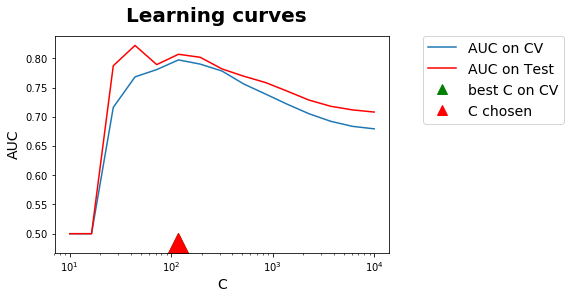

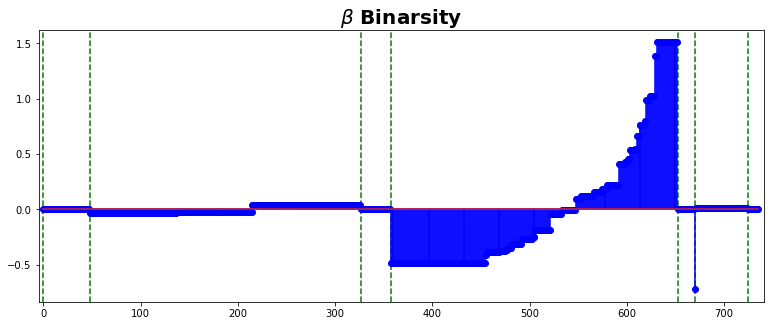

In [4]:
# logistic regression on binarized features, binarsity penalization
model = "Binarsity"

X_final = X_cont
X_test_final = X_test_cont

AUC = list()
times = list()

#for n_cuts in n_cuts_grid:
for n_cuts in [300]:

    print("Testing n_cuts=%s" % n_cuts)
    binarizer = FeaturesBinarizer(n_cuts=n_cuts)
    binarizer.fit(pd.concat([X_final, X_test_final], axis=0))

    X_final = X_cont.iloc[:n_restrict_cv, :]
    X_test_final = X_test_cont.iloc[:n_restrict_cv, :]

    X_bin = binarizer.transform(X_final)
    X_test_bin = binarizer.transform(X_test_final)

    # cross validation on C
    avg_scores, score_test = np.empty(0), []
    tmp = 0
    for i, C_ in enumerate(C_grid):
        tmp += 1
        stdout.write("\rCV %s: %d%%" % (model, tmp * 100 / C_grid_size))
        stdout.flush()

        learners = [LogisticRegression(penalty='binarsity', solver='svrg', C=C_,
                          verbose=False, step=1e-3,
                          blocks_start=binarizer.feature_indices[:-1, ],
                          blocks_length=binarizer.n_values)
            for _ in range(K)]
        auc = compute_score(learners, X_bin, y[:n_restrict_cv], K,
                            verbose=False)[0]

        avg_scores = np.append(avg_scores, max(auc, 1 - auc))

        learner = LogisticRegression(penalty='binarsity', solver='svrg',
                                C=C_, verbose=False, step=1e-3,
                                blocks_start=binarizer.feature_indices[
                                             :-1, ],
                                blocks_length=binarizer.n_values)
        learner.fit(X_bin, y[:n_restrict_cv])
        y_pred = learner.predict_proba(X_test_bin)[:, 1]
        auc = roc_auc_score(y_test[:n_restrict_cv], y_pred)
        auc = max(auc, 1 - auc)
        score_test.append(auc)

    idx_best = np.unravel_index(avg_scores.argmax(),
                                avg_scores.shape)[0]
    C_best = C_grid[idx_best]
    if selection == 'min':
        C_chosen = C_best
    if selection == '1st':
        max_ = avg_scores.max()
        min_ = avg_scores.min()
        idx = [i for i, is_up in enumerate(
            list(avg_scores >= max_ - .05 * (max_ - min_)))
               if is_up]
        idx_chosen = min(idx) if len(idx) > 0 else idx_best
        C_chosen = C_grid[idx_chosen]

    if verbose:
        ## display learning curves
        fig = pl.figure()
        ax = fig.add_subplot(111)
        pl.xscale('log')
        ax.plot(C_grid, avg_scores, label="AUC on CV")
        ax.plot(C_grid, score_test , '-r', 
                label="AUC on Test")
        y_min = ax.get_ylim()[0]
        ax.plot(C_best,y_min,'g^',ms=20, label="best C on CV")
        ax.plot(C_chosen,y_min,'r^',ms=20, label="C chosen")
        pl.suptitle("Learning curves", fontsize=20, fontweight="bold")
        pl.xlabel("C", fontsize=14)
        pl.ylabel("AUC", fontsize=14)
        pl.legend(bbox_to_anchor=(1.1,1), loc=2, borderaxespad=0.,
                  numpoints=1, markerscale=.5, fontsize=14)
        pl.show()

    X_final = X_cont
    X_test_final = X_test_cont

    binarizer = FeaturesBinarizer(n_cuts=n_cuts)
    binarizer.fit(pd.concat([X_final, X_test_final], axis=0))
    X_bin = binarizer.transform(X_final)
    X_test_bin = binarizer.transform(X_test_final)

    blocks_start = binarizer.feature_indices[:-1, ]
    blocks_length = binarizer.n_values

    start = time()
    learner = LogisticRegression(penalty='binarsity', solver='svrg', C=C_chosen,
                            verbose=False, step=1e-3,
                            blocks_start=blocks_start,
                            blocks_length=blocks_length)
    learner.fit(X_bin, y)
    y_pred = learner.predict_proba(X_test_bin)[:, 1]

    auc = roc_auc_score(y_test, y_pred)
    auc = max(auc, 1 - auc)
    AUC.append(auc)
    times.append(time() - start)
    
    if verbose:
        ## display coeff
        coeffs = learner.weights
        fig = pl.figure(figsize=(13,5))
        ax = fig.add_subplot(111)
        for val in blocks_start:
            ax.axvline(val, color='g', linestyle='--') 
        pl.title(r"$\beta$ %s" % model.replace('_',' '), 
                    fontsize=20, fontweight='bold')
        ax.stem(coeffs, 'b', markerfmt='ob')

        ax.set_xlim([-5, len(coeffs)+5])
        pl.show()

In [15]:
os.chdir('../../discretization_impact')
np.save('./results/AUC-%s' % filename, AUC)
np.save('./results/times-%s' % filename, times)
np.save('./results/n_cuts_grid-%s' % filename, n_cuts_grid)

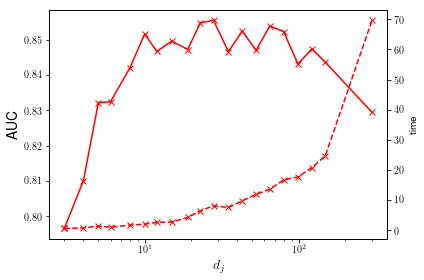

In [14]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

fig, ax1 = pl.subplots()

ax1.plot(n_cuts_grid, AUC , '-xr')
ax1.set_xlabel("$d_j$", fontsize=14)
ax1.set_ylabel("AUC", fontsize=14)

ax1.set_xscale('log')

ax2 = ax1.twinx()
ax2.plot(n_cuts_grid, times, '--xr')
ax2.set_ylabel('time')

ax1.set_xscale('log')

fig.tight_layout()
pl.show()